We solve the steady advection-diffusion equation $$-\kappa \Delta u + \mathbf{a}\cdot \nabla u = 0, \quad\text{where }\kappa =10^{-7} \text{ and } \mathbf{a} = \left(-y + 0.5\,,\,\, x - 0.5\right)^T $$

The domain is $0\le x, y\le 1$ and our solution satisfies the dirichlet boundary conditions indicated below 
<img src="files/ProblemSetup.png">




<img src="files/ProblemSolution.png">

(pictures taken from this [paper](https://link.springer.com/content/pdf/10.1007/s11831-010-9042-5.pdf))

In [1]:
import nutils as ntl
import numpy as np
import matplotlib.pyplot as plt
import inspect
from matplotlib import collections
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

## Galerkin

**Weak Form**: $$0 = \int_\Omega \kappa \, N_{A, j}\, u_{, j} \,-\, u\, N_{A, k} \,a_k \, dx$$
where $N_i$ is a basis function.

<class 'nutils.topology.DisjointUnionTopology'>
<class 'nutils.topology.Topology'>
optimize > solve > solving 90 dof system to machine precision using direct solver
optimize > solve > solver returned with residual 1e-18
optimize > constrained 90/441 dofs
optimize > optimum value 5.75e-08
solve > solving 351 dof system to machine precision using direct solver
solve > solver returned with residual 9e-18


<IPython.core.display.Javascript object>


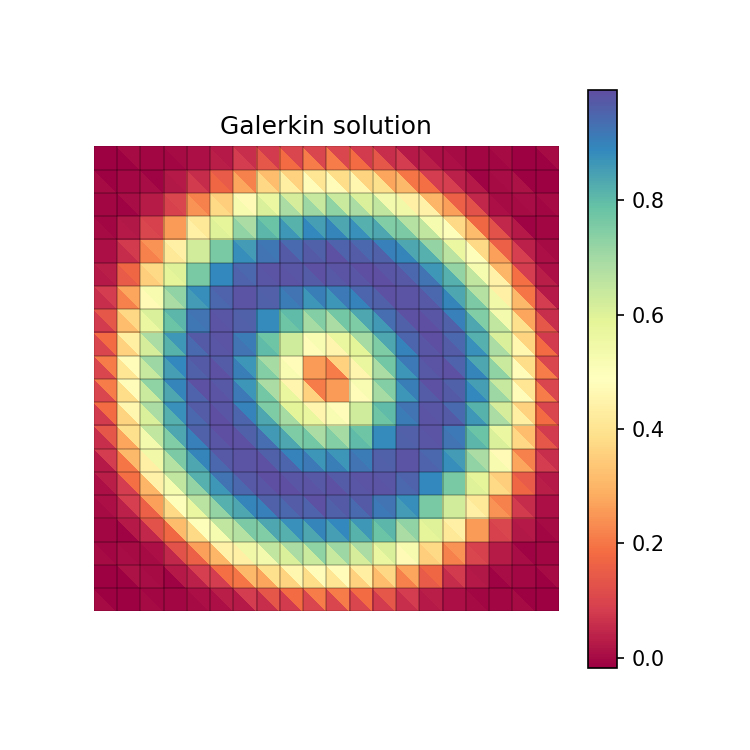

<IPython.core.display.Javascript object>


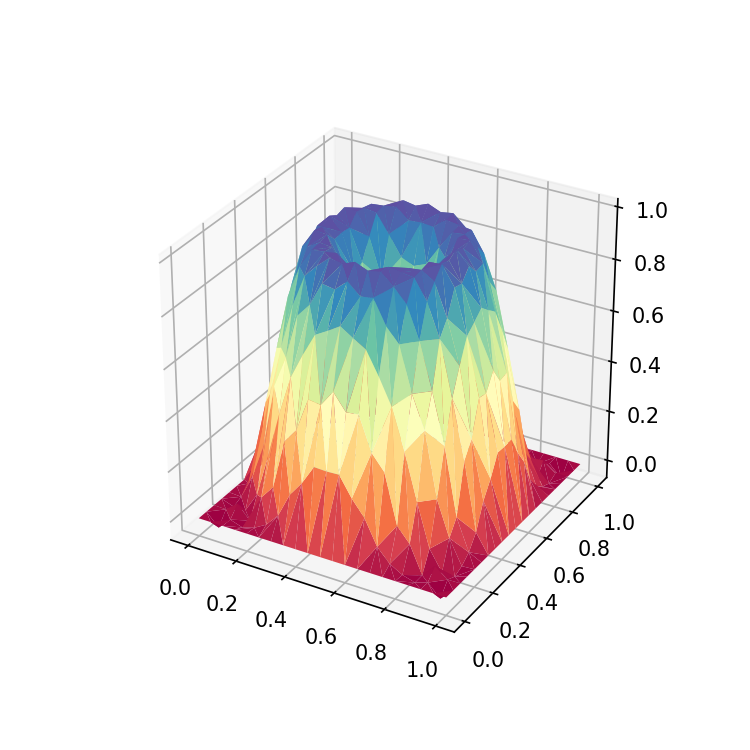

In [33]:
import nutils as ntl
import numpy as np
import matplotlib.pyplot as plt
import inspect
from matplotlib import collections
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

degree = 1 #degree of basis functions
nelems = 20 #number of elements along edge of unit square
etype = 'square' #square meshes


topo, geom =ntl.mesh.unitsquare(nelems, etype) #ntl.mesh.gmsh('domain.msh') #
ns = ntl.function.Namespace()
ns.x = geom
ns.a = [- geom[1] + 0.5, geom[0] - 0.5]  
ns.kappa = 1e-7
ns.pi = np.pi
ns.basis = topo.basis('lagrange', degree = degree)
ns.u = 'basis_i ?dofs_i'
ns.f = ntl.function.sin(np.pi * ( geom[0] - 0.5 ))

#Dirichlet boundary condition

#sqr = topo.boundary['midline'].integral('( u - sin(pi (x_0 - 0.5)) )^2 d:x' @ ns, degree = degree * 2)


 
print(type(topo.boundary))    
#tophalf of domain is defined via y - 0.5 > 0. Midline is one of the boundaries of this new domain 

halftopo = topo.trim(geom[1] - 0.50, maxrefine = 0, name= 'halfbnd') 

halfbnd = halftopo.boundary['halfbnd']
madline = halfbnd.trim(geom[0] - 0.5, maxrefine = 0, name = 'madline')

#left, ns.right = ntl.function.partition(geom[0], 0.5) 
print(type(halfbnd))

sqr = madline.integral('( u - abs(sin(2 pi (x_0 - 0.5)))  )^2 d:x' @ ns, degree = degree * 2)#

#sqr = topo.boundary['midline'].integral('( u - abs(sin(pi (x_0 - 0.5)))  )^2 d:x' @ ns, degree = degree * 2)
sqr += topo.boundary['left'].integral( '(u - 0)^2 d:x' @ ns, degree = degree*2 )
sqr += topo.boundary['bottom'].integral('(u - 0)^2 d:x' @ ns, degree = degree*2)
sqr += topo.boundary['right'].integral( '(u - 0)^2 d:x' @ ns, degree = degree*2 )
sqr += topo.boundary['top'].integral( '(u - 0)^2 d:x' @ ns, degree = degree*2 )
cons = ntl.solver.optimize('dofs', sqr, droptol=1e-15) #this applies the boundary condition to u

#residual
res = topo.integral( '(kappa basis_i,j u_,j  - u basis_i,n a_n) d:x' @ ns, degree = degree * 2) 

lhs = ntl.solver.solve_linear('dofs', res, constrain= cons)

bezier = topo.sample('bezier', 2)
x = bezier.eval('x_i' @ ns)
u = bezier.eval('u' @ ns, dofs = lhs)

#ntl.export.triplot('RF_Gal.png', x, u, tri=bezier.tri, hull=bezier.hull)
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(111, aspect= 'equal')
im = ax.tripcolor(x[:,0], x[:, 1], bezier.tri, u, cmap = plt.cm.Spectral)
fig.colorbar(im)
ax.autoscale(enable= True, axis = 'both', tight = 'True')
ax.set_title('Galerkin solution')
ax.add_collection(collections.LineCollection(x[bezier.hull], colors='k', linewidths= .1))
plt.axis('off')

fig2 = plt.figure(figsize= (5,5))
ax2 = fig2.add_subplot(111, projection ='3d')
ax2.plot_trisurf( x[:, 0], x[:,1], u, cmap=plt.cm.Spectral)

## SUPG

**Weak Form**:
$$0 = \int_\Omega \kappa \, N_{A, j}\, u_{, j} \,-\, u\, N_{A, k}\,a_k \, dx + \int_\Omega \tau\, a_n N_{A, n} 
( - \kappa\, u_{, mm} + a_k\, u_{,k}) \, dx$$

We use $\tau = \frac{h}{2|a|}$ in the code below

1 <class 'nutils.topology.Topology'>
optimize > solve > solving 90 dof system to machine precision using direct solver
optimize > solve > solver returned with residual 1e-18
optimize > constrained 90/441 dofs
optimize > optimum value 5.75e-08
solve > solving 351 dof system to machine precision using direct solver
solve > solver returned with residual 2e-17


<IPython.core.display.Javascript object>


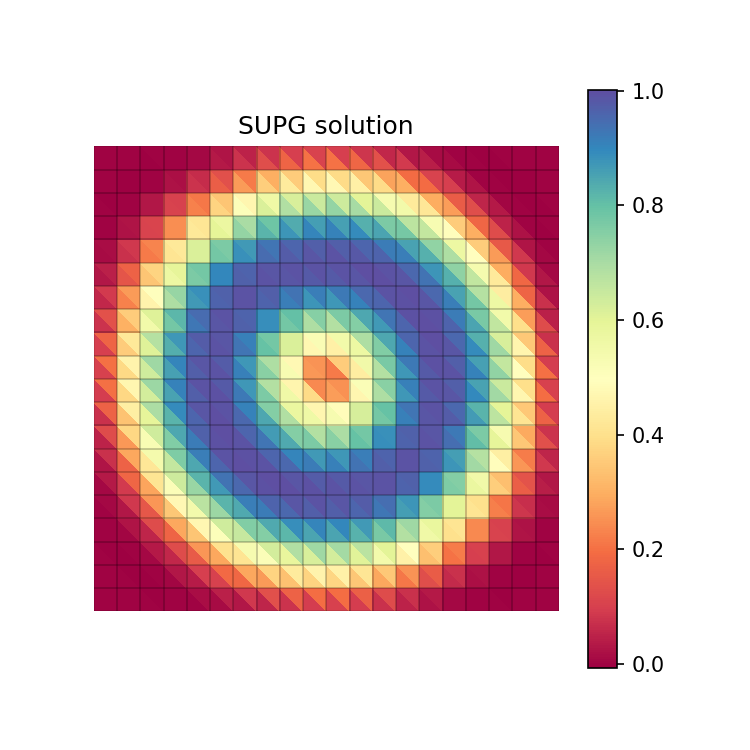

<IPython.core.display.Javascript object>


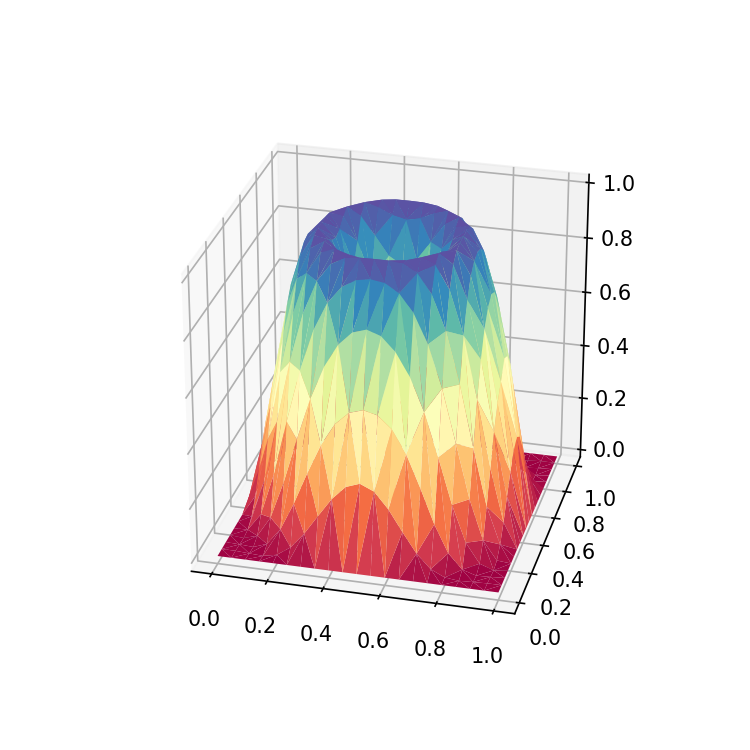

In [29]:
import nutils as ntl
import numpy as np
import matplotlib.pyplot as plt
import inspect
from matplotlib import collections
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

degree = 1 #degree of basis functions
nelems = 20 #number of elements along edge of unit square
etype = 'square' #square meshes


topo, geom =  ntl.mesh.unitsquare(nelems, etype) 
ns = ntl.function.Namespace()
ns.x = geom
ns.a = [- geom[1] + 0.5, geom[0] - 0.5]  
ns.kappa = 1e-7
ns.pi = np.pi
ns.basis = topo.basis('lagrange', degree = degree)
ns.u = 'basis_i ?dofs_i'

#element intrinsic time scale
ns.h = np.sqrt(2/nelems**2) #mesh size parameter
ns.anorm = '(a_i a_i)^.5'
ns.tau = 'h / (2 anorm)'

#dirichlet boundary conditions

halftopo = topo.trim(geom[1] - 0.5, maxrefine = 5, name= 'halfbnd') #this creates a topology for top half of square domain

halfbnd = halftopo.boundary['halfbnd'] #the midline is one of the boundaries of the top
print(halfbnd.ndims, type(halfbnd))
madline = halfbnd.trim(geom[0] - 0.5, maxrefine = 0, name = 'madline')

sqr = madline.integral('( u - abs(sin(2 pi (x_0 - 0.5))) )^2 d:x' @ ns, degree = degree * 2)
sqr += topo.boundary['top'].integral( '(u - 0)^2 d:x' @ ns, degree = degree*2 )
sqr += topo.boundary['bottom'].integral('(u - 0)^2 d:x' @ ns, degree = degree*2)
sqr += topo.boundary['left'].integral( '(u - 0)^2 d:x' @ ns, degree = degree*2 )
sqr += topo.boundary['right'].integral( '(u - 0)^2 d:x' @ ns, degree = degree*2 )

cons = ntl.solver.optimize('dofs', sqr, droptol=1e-15) #this applies the boundary condition to u

#residual
res = topo.integral( '(kappa basis_i,j u_,j  - u basis_i,n a_n) d:x' @ ns, degree = degree * 2) 
res += topo.integral( 'tau a_k basis_i,k (-kappa u_,jj + a_n u_,n)  d:x' @ ns, degree = degree * 2) 

lhs = ntl.solver.solve_linear('dofs', res, constrain= cons)

bezier = topo.sample('bezier', 2)
x = bezier.eval('x_i' @ ns)
u = bezier.eval('u' @ ns, dofs = lhs)

#ntl.export.triplot('RF_SUPG.png', x, u, tri=bezier.tri, hull=bezier.hull)
fig = plt.figure(figsize= (5, 5))
ax = fig.add_subplot(111, aspect= 'equal')
im = ax.tripcolor(x[:,0], x[:, 1], bezier.tri, u, cmap= plt.cm.Spectral)
fig.colorbar(im)
ax.autoscale(enable= True, axis = 'both', tight = 'True')
ax.set_title('SUPG solution')
ax.add_collection(collections.LineCollection(x[bezier.hull], colors='k', linewidths= .1))
plt.axis('off')

fig2 = plt.figure(figsize= (5,5))
ax2 = fig2.add_subplot(111, projection ='3d')
ax2.plot_trisurf( x[:, 0], x[:,1], u, cmap=plt.cm.Spectral)


## Galerkin/Least Squares

**Weak Form**:
$$0 = \int_\Omega \kappa \, N_{A, j}\, u_{, j} \,-\, u\, N_{A, k}\,a_k \, dx + \int_\Omega \tau\, (-\kappa\,N_{A, rr}\,+\, a_n N_{A, n}) 
( - \kappa\, u_{, mm} + a_k\, u_{,k}) \, dx$$

We use $\tau = \frac{h}{2|a|}$ in the code below. (In the code below I use quadratic basis elements. Otherwise the method reduce to SUPG)

1 <class 'nutils.topology.Topology'>
optimize > solve > solving 270 dof system to machine precision using direct solver
optimize > solve > solver returned with residual 1e-17
optimize > constrained 270/3721 dofs
optimize > optimum value 4.20e-10
solve > solving 3451 dof system to machine precision using direct solver
solve > solver returned with residual 9e-17


<IPython.core.display.Javascript object>


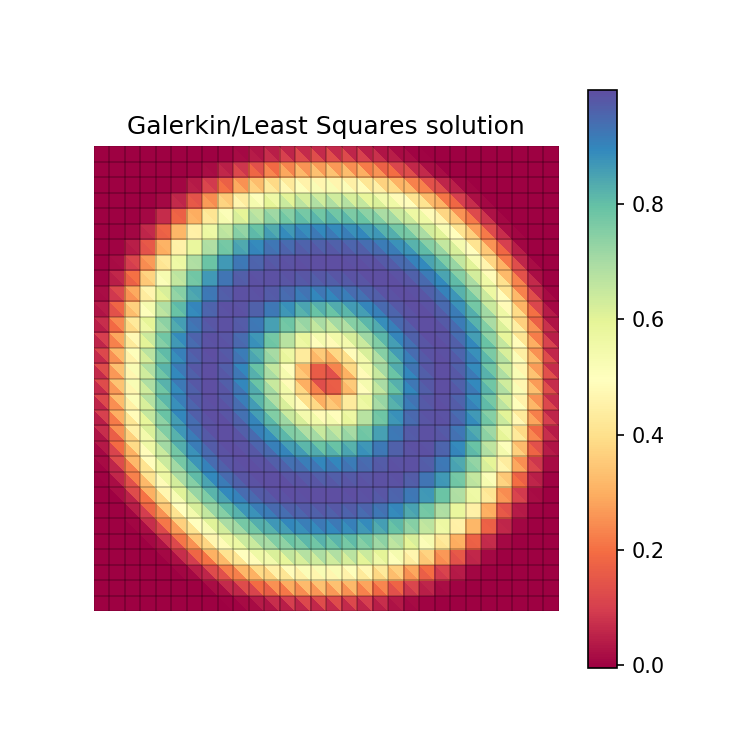

<IPython.core.display.Javascript object>


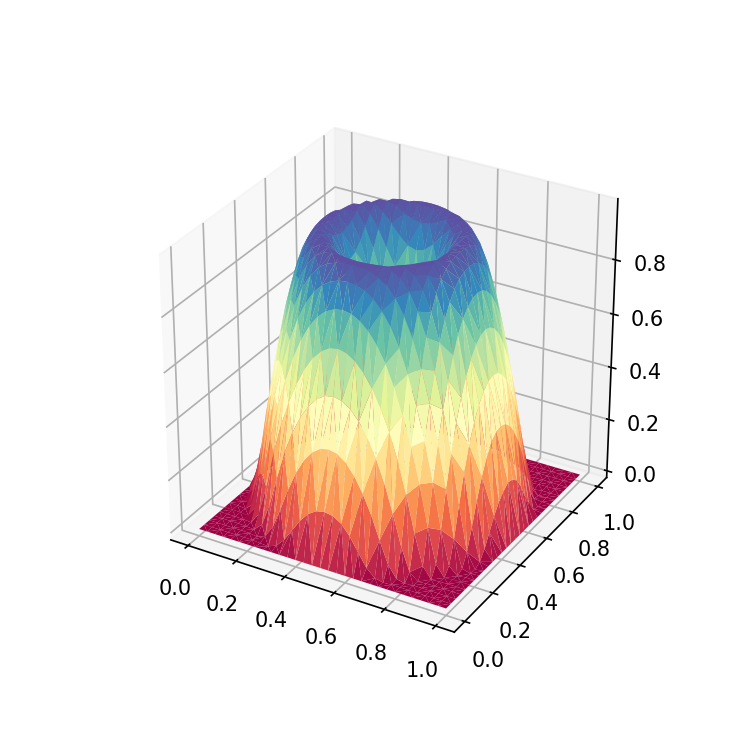

In [24]:
import nutils as ntl
import numpy as np
import matplotlib.pyplot as plt
import inspect
from matplotlib import collections
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

degree = 2 #degree of basis functions
nelems = 30 #number of elements along edge of unit square
etype = 'square' #square meshes


topo, geom =  ntl.mesh.unitsquare(nelems, etype) 
ns = ntl.function.Namespace()
ns.x = geom
ns.a = [- geom[1] + 0.5, geom[0] - 0.5]  
ns.kappa = 1e-7
ns.pi = np.pi
ns.basis = topo.basis('lagrange', degree = degree)
ns.u = 'basis_i ?dofs_i'

#element intrinsic time scale
ns.h = np.sqrt(2/nelems**2) #mesh size parameter
ns.anorm = '(a_i a_i)^.5'
ns.tau = 'h / (2 anorm)'

#dirichlet boundary conditions

halftopo = topo.trim(geom[1] - 0.5, maxrefine = 5, name= 'halfbnd') #this creates a topology for top half of square domain

halfbnd = halftopo.boundary['halfbnd'] #the midline is one of the boundaries of the top
print(halfbnd.ndims, type(halfbnd))
madline = halfbnd.trim(geom[0] - 0.5, maxrefine = 0, name = 'madline')


sqr = topo.boundary['top'].integral( '(u - 0)^2 d:x' @ ns, degree = degree*2 )
sqr += topo.boundary['bottom'].integral('(u - 0)^2 d:x' @ ns, degree = degree*2)
sqr += topo.boundary['left'].integral( '(u - 0)^2 d:x' @ ns, degree = degree*2 )
sqr += topo.boundary['right'].integral( '(u - 0)^2 d:x' @ ns, degree = degree*2 )
sqr += madline.integral('( u - abs(sin(2 pi (x_0 - 0.5))) )^2 d:x' @ ns, degree = degree * 2)

cons = ntl.solver.optimize('dofs', sqr, droptol=1e-15) #this applies the boundary condition to u

#residual
res = topo.integral( '(kappa basis_i,j u_,j  - u basis_i,n a_n) d:x' @ ns, degree = degree * 2) 
res += topo.integral('tau (-kappa basis_i,mm + a_k basis_i,k) (-kappa u_,jj + a_n u_,n)  d:x' @ ns,
                     degree= degree * 2) 
lhs = ntl.solver.solve_linear('dofs', res, constrain= cons)

bezier = topo.sample('bezier', 2)
x = bezier.eval('x_i' @ ns)
u = bezier.eval('u' @ ns, dofs = lhs)

#ntl.export.triplot('ADSM_GLS.png', x, u, tri=bezier.tri, hull=bezier.hull)
fig = plt.figure(figsize= (5,5))
ax = fig.add_subplot(111, aspect= 'equal')
im = ax.tripcolor(x[:,0], x[:, 1], bezier.tri, u, cmap= plt.cm.Spectral)
fig.colorbar(im)
ax.autoscale(enable= True, axis = 'both', tight = 'True')
ax.set_title('Galerkin/Least Squares solution')
ax.add_collection(collections.LineCollection(x[bezier.hull], colors='k', linewidths= .1))
plt.axis('off')

fig2 = plt.figure(figsize= (5,5))
ax2 = fig2.add_subplot(111, projection ='3d')
ax2.plot_trisurf( x[:, 0], x[:,1], u, cmap=plt.cm.Spectral)

In [20]:
help(halftopo.references)

Help on SelectedReferences in module nutils.elementseq object:

class SelectedReferences(References)
 |  SelectedReferences(parent, indices)
 |  
 |  A selection of references.  Duplication and reordering is allowed.
 |  
 |  Parameters
 |  ----------
 |  parent : :class:`References`
 |      The transforms to subset.
 |  indices : one-dimensional array of :class:`int`\s
 |      Indices of ``parent`` that form this selection.
 |  
 |  Method resolution order:
 |      SelectedReferences
 |      References
 |      nutils.types.Singleton
 |      nutils.types.Immutable
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __getitem__(self, index)
 |      Return ``self[index]``.
 |  
 |  __init__(self, parent, indices)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __len__(self)
 |      Return ``len(self)``.
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  __abstract